## OpenCV

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

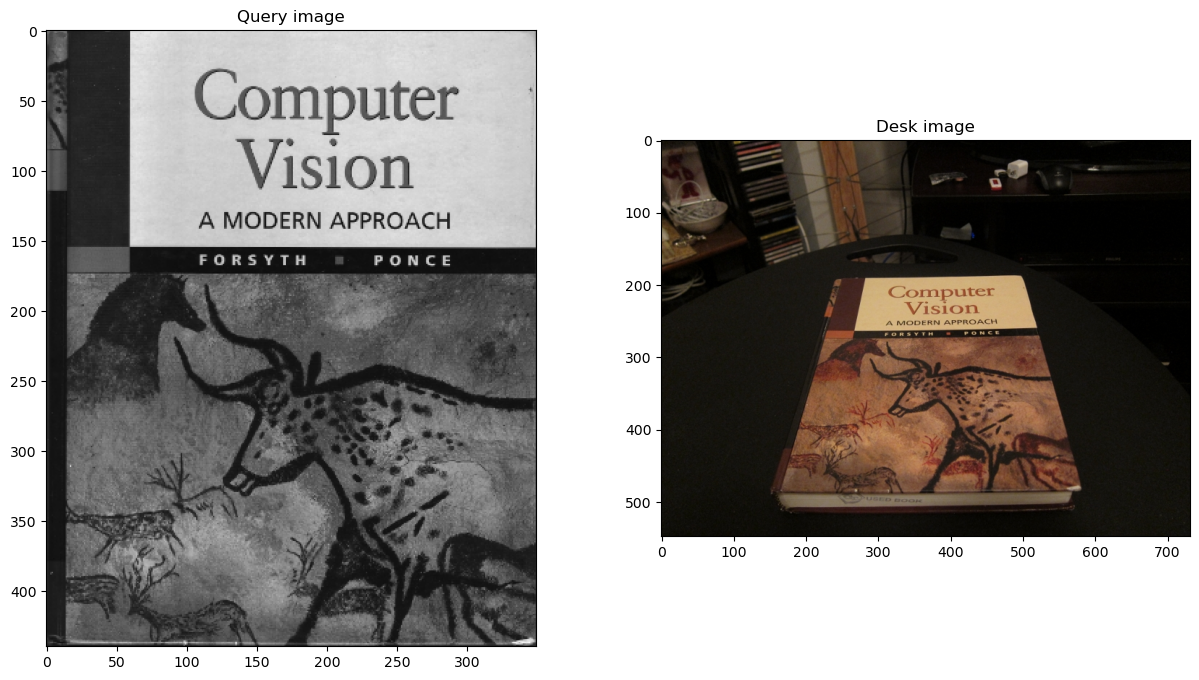

In [4]:
queryImage= './data/cv_cover.jpg'
trainImage='./data/cv_desk.png'

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(cv2.imread(queryImage), cv2.COLOR_BGR2RGB))
plt.title('Query image')
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(cv2.imread(trainImage), cv2.COLOR_BGR2RGB))
plt.title('Desk image')
plt.show()

## ORB

In [6]:
# Initiate ORB detector
img1 = cv2.imread(queryImage,cv2.IMREAD_GRAYSCALE)         
img2 = cv2.imread(trainImage,cv2.IMREAD_GRAYSCALE)

In [7]:
# ORB
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

In [8]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2)

# Sort them in the order of their distance
matches = sorted(matches, key = lambda x:x.distance)

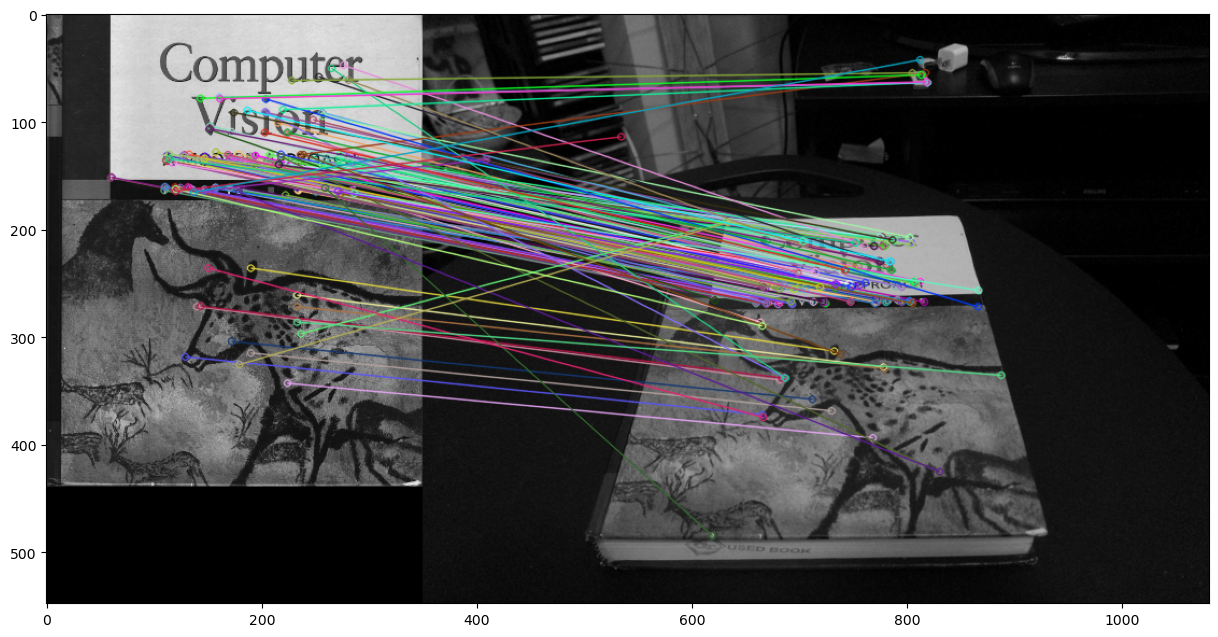

In [9]:
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 8))
plt.imshow(img3)
plt.show()

## RANSAC
#### Find homography and warping

In [16]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)
for i, match in enumerate(matches):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt
    
# h는 3 * 3 matrix
h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

print(h)
print(mask.shape)

height, width = img2.shape

# warping
im1_warped = cv2.warpPerspective(img1, h, (width, height))

[[ 7.26561847e-01 -3.43595535e-01  2.38299920e+02]
 [-2.82391061e-02  2.29258465e-01  1.93738977e+02]
 [-5.71271121e-05 -9.05462166e-04  1.00000000e+00]]
(144, 1)


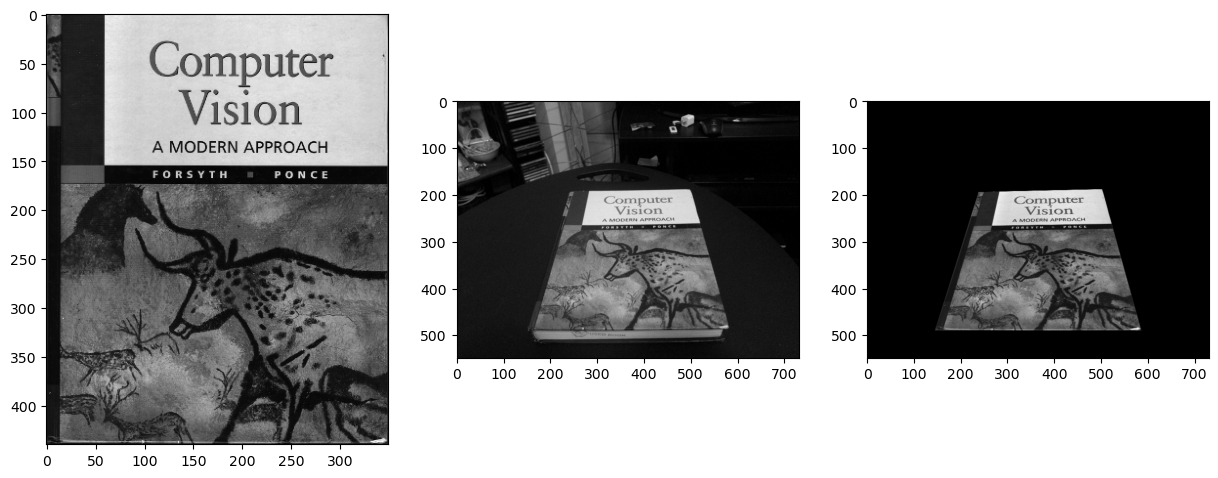

In [11]:
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.imshow(img1, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(img2, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(im1_warped, cmap='gray')
plt.show()

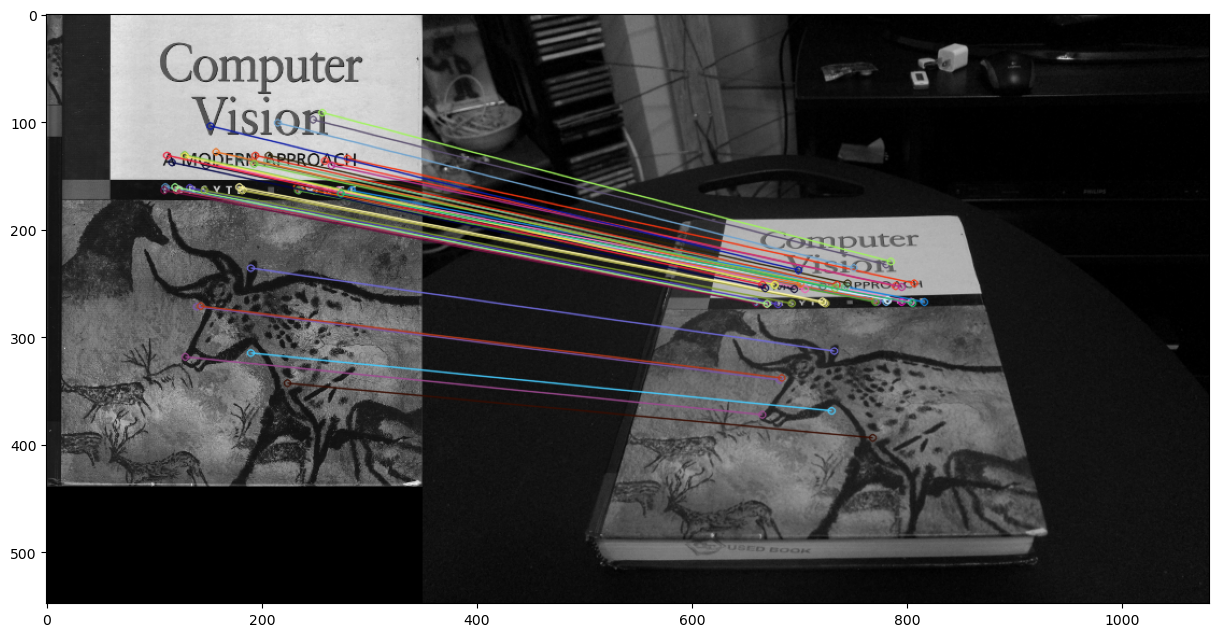

In [12]:
matches_opencv_ransac = np.array(matches)[np.nonzero(mask.squeeze())]
img3 = cv2.drawMatches(img1,kp1,img2,kp2, matches_opencv_ransac, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15,8))
plt.imshow(img3)
plt.show()

## Kornia

tensor([[ 7.4868e-01, -3.5523e-01,  2.3902e+02],
        [-5.9872e-03,  2.2243e-01,  1.9257e+02],
        [ 6.1472e-06, -9.2738e-04,  1.0000e+00]])
torch.Size([144]) (144, 2) (144, 2)


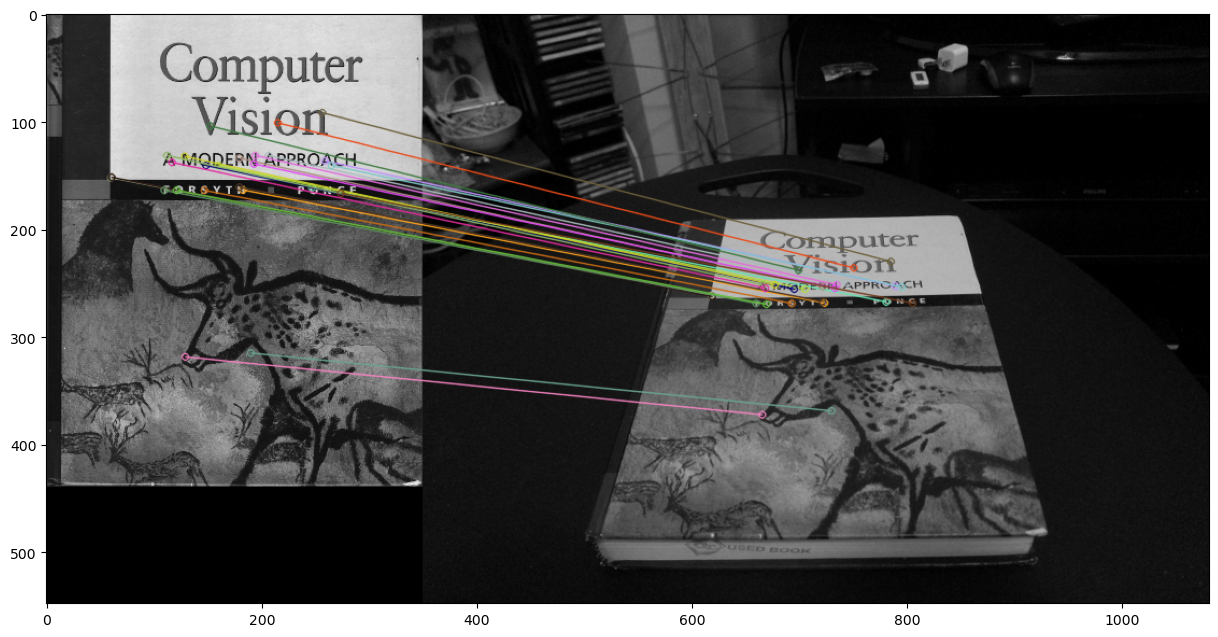

In [14]:
import torch
import kornia.geometry as KG
ransac = KG.ransac.RANSAC(model_type='homography')

# print(points1, points2, points2.shape)
H, inliers = ransac(torch.tensor(points1), torch.tensor(points2))
print(H)
print(inliers.shape, points1.shape, points2.shape)

matches_kornia = np.array(matches)[np.nonzero(inliers.squeeze())][:, 0]

img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches_kornia,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15,8))
plt.imshow(img3)
plt.show()

In [15]:
ransac = KG.ransac.RANSAC(model_type='fundamental')
F, inliers = ransac(torch.tensor(points1), torch.tensor(points2))
print(F) # fundamental matrix

tensor([[-4.5059e-05,  1.2509e-03, -1.9867e-01],
        [-2.8523e-03,  3.6474e-04,  1.8397e-01],
        [ 7.8003e-01, -4.1671e-01,  1.0000e+00]])
